# EuroSAT Dataset Applying Pre-trained CNN (ResNet50)

In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
import platform
import psutil
import random
import cv2
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
from PIL import ImageOps

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.models as models

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchinfo import summary
from torchsummary import summary

from collections import OrderedDict

from tabulate import tabulate

### Configuration

In [2]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [3]:
seed = 5
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [4]:
data_dir = "/kaggle/input/eurosat-dataset/EuroSAT"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
     if not class_name.lower().endswith(('.csv', '.json')):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

### Class Count & Bar Plot

class: HerbaceousVegetation --> count: 3000
class: AnnualCrop --> count: 3000
class: Forest --> count: 3000
class: SeaLake --> count: 3000
class: Residential --> count: 3000
class: PermanentCrop --> count: 2500
class: Industrial --> count: 2500
class: River --> count: 2500
class: Highway --> count: 2500
class: Pasture --> count: 2000


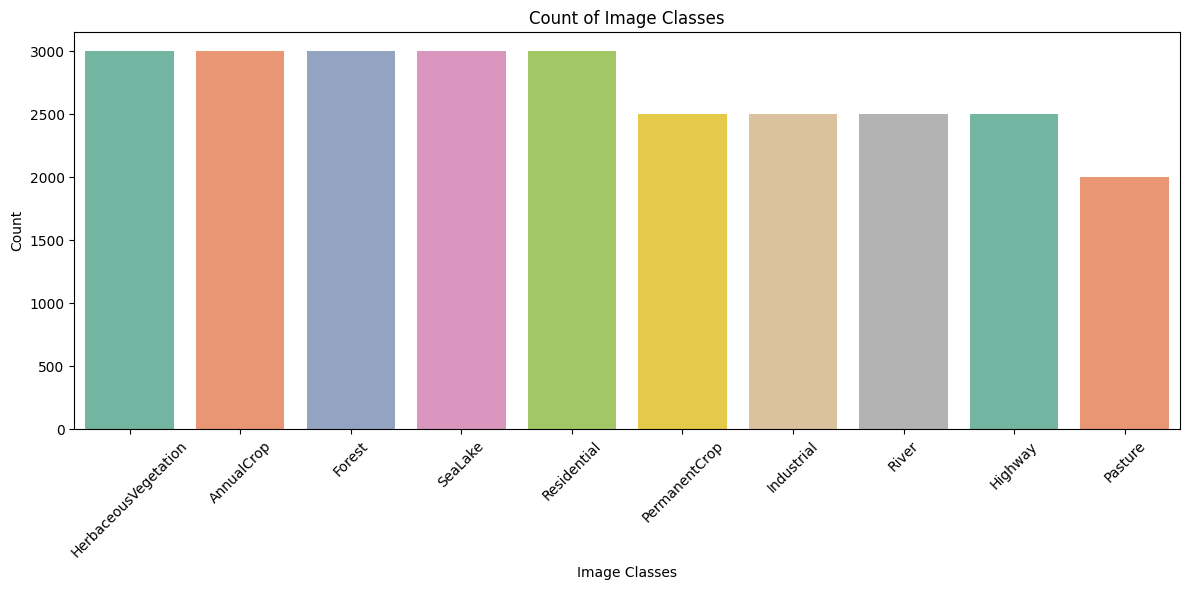

In [5]:
# Class count and Bar plot
class_count = df['label'].value_counts()

for class_name , count in class_count.items():
    print(f"class: {class_name} --> count: {count}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='Set2')
plt.title('Count of Image Classes')
plt.xlabel('Image Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sample Images From Each Classes

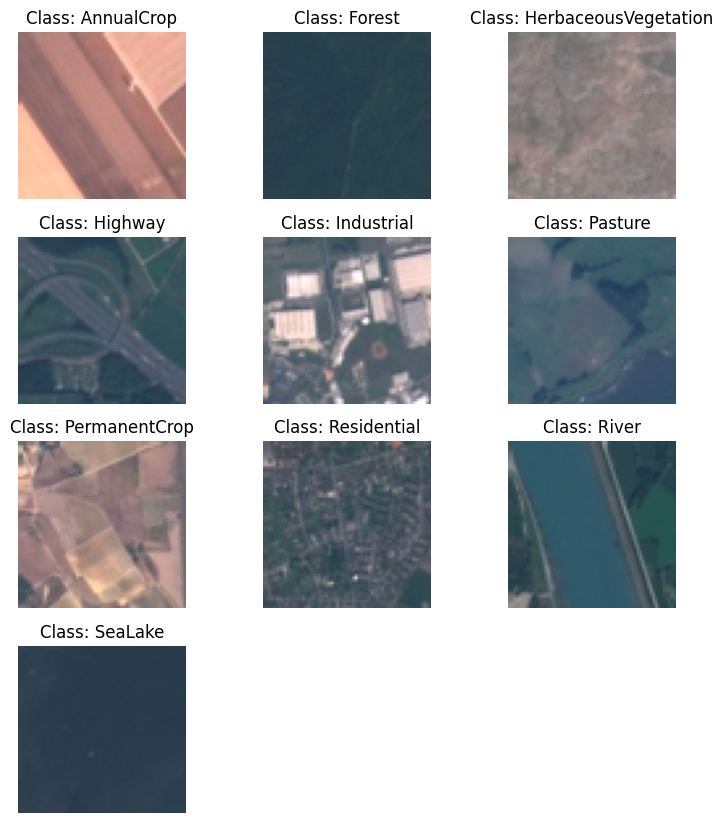

In [6]:
# Get class names
class_names = sorted(df['label'].unique())

# set up figure
plt.figure(figsize=(3 * 2.5, len(class_names) / 3  * 2.5))

# One sample image per class
for i, class_name in enumerate(class_names):
    try:
        # get sample for this class
        path = df[df['label'] == class_name]['file_path'].sample(1).values[0]
        with Image.open(path) as img:
            plt.subplot(int(len(class_names) / 3)+1, 3, i+1)
            plt.imshow(img)
            plt.title(f"Class: {class_name}")
            plt.axis('off')
    except Exception as e:
        print(f"Error reading image {path}: {e}")
        continue
    

plt.tight_layout()
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [7]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [8]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18900
Validation Data:  4050
Test Data:  4050
-------------------------------------------
Total amounts of data in the dataset:  27000


In [9]:

class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                   Count
--------------------  -------
Residential              2100
SeaLake                  2100
AnnualCrop               2100
Forest                   2100
HerbaceousVegetation     2100
PermanentCrop            1750
Industrial               1750
Highway                  1750
River                    1750
Pasture                  1400

Validation Dataset
Class                   Count
--------------------  -------
AnnualCrop                450
SeaLake                   450
Residential               450
HerbaceousVegetation      450
Forest                    450
Highway                   375
Industrial                375
PermanentCrop             375
River                     375
Pasture                   300

Test Dataset
Class                   Count
--------------------  -------
SeaLake                   450
AnnualCrop                450
Forest                    450
HerbaceousVegetation      450
Residential               450
PermanentCrop         

Label mapping

In [10]:
classes = sorted(df['label'].unique())
label_map = {class_name: i for i, class_name in enumerate(classes)}
print(label_map)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


### Device Variable

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [12]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Integrate Class-weight Loss

In [13]:
# Extract class labels from your training dataframe
train_labels = train_dataframe['label'].map(label_map).values
num_classes = len(classes)

# print(np.unique(train_labels))
# print(np.arange(num_classes))

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

### Dataset Class, Dataloader and Transform

In [14]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = label_map
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [15]:
train_batch = 64
val_batch = 8

def data_transfrom():
    size = 224
    normalize = transforms.Compose([
            transforms.Resize((size,size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
    ])
    
    train_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ])

    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

### Neural Network (ResNet)

In [16]:
total_class = 10
learning_rate = 0.0001

model = models.resnet50(pretrained=False)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, total_class)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
summary(model, input_size=(3, 224, 224))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### Training

In [17]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=150, early_stop_patience=150, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"✅ Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"⏹️ Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model,
    criterion,
    optimizer,
    dataloader_train_dataset,
    dataloader_valid_dataset,
    save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/150: 100%|██████████| 296/296 [01:45<00:00,  2.80it/s, acc=0.553, loss=1.25]

Training Loss: 1.247 Acc: 0.553


Validation Loss: 1.170 Acc: 0.602
✅ Best model saved at epoch 1 with validation accuracy: 0.602


Epoch 2/150: 100%|██████████| 296/296 [01:36<00:00,  3.05it/s, acc=0.676, loss=0.931]

Training Loss: 0.931 Acc: 0.676


Validation Loss: 0.808 Acc: 0.714
✅ Best model saved at epoch 2 with validation accuracy: 0.714


Epoch 3/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.733, loss=0.768]

Training Loss: 0.768 Acc: 0.733


Validation Loss: 1.135 Acc: 0.650


Epoch 4/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.78, loss=0.639] 

Training Loss: 0.639 Acc: 0.780


Validation Loss: 1.266 Acc: 0.612


Epoch 5/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.806, loss=0.57] 

Training Loss: 0.570 Acc: 0.806


Validation Loss: 0.592 Acc: 0.795
✅ Best model saved at epoch 5 with validation accuracy: 0.795


Epoch 6/150: 100%|██████████| 296/296 [01:36<00:00,  3.05it/s, acc=0.836, loss=0.48] 

Training Loss: 0.480 Acc: 0.836


Validation Loss: 0.681 Acc: 0.785


Epoch 7/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.854, loss=0.427]

Training Loss: 0.427 Acc: 0.854


Validation Loss: 1.088 Acc: 0.701


Epoch 8/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.87, loss=0.376] 

Training Loss: 0.376 Acc: 0.870


Validation Loss: 0.482 Acc: 0.839
✅ Best model saved at epoch 8 with validation accuracy: 0.839


Epoch 9/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.879, loss=0.357]

Training Loss: 0.357 Acc: 0.879


Validation Loss: 0.331 Acc: 0.884
✅ Best model saved at epoch 9 with validation accuracy: 0.884


Epoch 10/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.89, loss=0.323] 

Training Loss: 0.323 Acc: 0.890


Validation Loss: 0.392 Acc: 0.877


Epoch 11/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.896, loss=0.302]

Training Loss: 0.302 Acc: 0.896


Validation Loss: 1.067 Acc: 0.728


Epoch 12/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.903, loss=0.278]

Training Loss: 0.278 Acc: 0.903


Validation Loss: 0.513 Acc: 0.845


Epoch 13/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.912, loss=0.262]

Training Loss: 0.262 Acc: 0.912


Validation Loss: 1.419 Acc: 0.690


Epoch 14/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.913, loss=0.253]

Training Loss: 0.253 Acc: 0.913


Validation Loss: 1.425 Acc: 0.680


Epoch 15/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.919, loss=0.24] 

Training Loss: 0.240 Acc: 0.919


Validation Loss: 0.286 Acc: 0.908
✅ Best model saved at epoch 15 with validation accuracy: 0.908


Epoch 16/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.925, loss=0.219]

Training Loss: 0.219 Acc: 0.925


Validation Loss: 0.252 Acc: 0.916
✅ Best model saved at epoch 16 with validation accuracy: 0.916


Epoch 17/150: 100%|██████████| 296/296 [01:36<00:00,  3.05it/s, acc=0.925, loss=0.213]

Training Loss: 0.213 Acc: 0.925


Validation Loss: 0.602 Acc: 0.818


Epoch 18/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.926, loss=0.211]

Training Loss: 0.211 Acc: 0.926


Validation Loss: 0.305 Acc: 0.908


Epoch 19/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.934, loss=0.196]

Training Loss: 0.196 Acc: 0.934


Validation Loss: 0.197 Acc: 0.929
✅ Best model saved at epoch 19 with validation accuracy: 0.929


Epoch 20/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.937, loss=0.184]

Training Loss: 0.184 Acc: 0.937


Validation Loss: 0.764 Acc: 0.813


Epoch 21/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.937, loss=0.178]

Training Loss: 0.178 Acc: 0.937


Validation Loss: 0.179 Acc: 0.942
✅ Best model saved at epoch 21 with validation accuracy: 0.942


Epoch 22/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.938, loss=0.178]

Training Loss: 0.178 Acc: 0.938


Validation Loss: 0.207 Acc: 0.933


Epoch 23/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.94, loss=0.173] 

Training Loss: 0.173 Acc: 0.940


Validation Loss: 0.274 Acc: 0.910


Epoch 24/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.942, loss=0.171]

Training Loss: 0.171 Acc: 0.942


Validation Loss: 0.287 Acc: 0.903


Epoch 25/150: 100%|██████████| 296/296 [01:36<00:00,  3.06it/s, acc=0.944, loss=0.161]

Training Loss: 0.161 Acc: 0.944


Validation Loss: 0.188 Acc: 0.942


Epoch 26/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.946, loss=0.15] 

Training Loss: 0.150 Acc: 0.946


Validation Loss: 0.536 Acc: 0.845


Epoch 27/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.946, loss=0.151]

Training Loss: 0.151 Acc: 0.946


Validation Loss: 0.237 Acc: 0.922


Epoch 28/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.949, loss=0.144]

Training Loss: 0.144 Acc: 0.949


Validation Loss: 0.208 Acc: 0.933


Epoch 29/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.952, loss=0.139]

Training Loss: 0.139 Acc: 0.952


Validation Loss: 0.271 Acc: 0.909


Epoch 30/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.952, loss=0.132]

Training Loss: 0.132 Acc: 0.952


Validation Loss: 0.292 Acc: 0.916


Epoch 31/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.954, loss=0.132]

Training Loss: 0.132 Acc: 0.954


Validation Loss: 0.362 Acc: 0.898


Epoch 32/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.951, loss=0.14] 

Training Loss: 0.140 Acc: 0.951


Validation Loss: 0.918 Acc: 0.855


Epoch 33/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.954, loss=0.13] 

Training Loss: 0.130 Acc: 0.954


Validation Loss: 0.299 Acc: 0.900


Epoch 34/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.96, loss=0.116] 

Training Loss: 0.116 Acc: 0.960


Validation Loss: 0.285 Acc: 0.917


Epoch 35/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.956, loss=0.124]

Training Loss: 0.124 Acc: 0.956


Validation Loss: 0.147 Acc: 0.951
✅ Best model saved at epoch 35 with validation accuracy: 0.951


Epoch 36/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.958, loss=0.124]

Training Loss: 0.124 Acc: 0.958


Validation Loss: 0.210 Acc: 0.939


Epoch 37/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.96, loss=0.114] 

Training Loss: 0.114 Acc: 0.960


Validation Loss: 0.236 Acc: 0.923


Epoch 38/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.961, loss=0.113]

Training Loss: 0.113 Acc: 0.961


Validation Loss: 0.999 Acc: 0.763


Epoch 39/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.961, loss=0.109]

Training Loss: 0.109 Acc: 0.961


Validation Loss: 0.147 Acc: 0.956
✅ Best model saved at epoch 39 with validation accuracy: 0.956


Epoch 40/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.962, loss=0.106]

Training Loss: 0.106 Acc: 0.962


Validation Loss: 0.292 Acc: 0.917


Epoch 41/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.968, loss=0.0929]

Training Loss: 0.093 Acc: 0.968


Validation Loss: 0.168 Acc: 0.950


Epoch 42/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.962, loss=0.102] 

Training Loss: 0.102 Acc: 0.962


Validation Loss: 0.217 Acc: 0.936


Epoch 43/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.965, loss=0.104]

Training Loss: 0.104 Acc: 0.965


Validation Loss: 0.120 Acc: 0.962
✅ Best model saved at epoch 43 with validation accuracy: 0.962


Epoch 44/150: 100%|██████████| 296/296 [01:36<00:00,  3.05it/s, acc=0.967, loss=0.09]  

Training Loss: 0.090 Acc: 0.967


Validation Loss: 0.845 Acc: 0.852


Epoch 45/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.969, loss=0.0868]

Training Loss: 0.087 Acc: 0.969


Validation Loss: 0.172 Acc: 0.947


Epoch 46/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.964, loss=0.098] 

Training Loss: 0.098 Acc: 0.964


Validation Loss: 0.181 Acc: 0.943


Epoch 47/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.97, loss=0.0854] 

Training Loss: 0.085 Acc: 0.970


Validation Loss: 0.125 Acc: 0.964
✅ Best model saved at epoch 47 with validation accuracy: 0.964


Epoch 48/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.973, loss=0.0799]

Training Loss: 0.080 Acc: 0.973


Validation Loss: 0.117 Acc: 0.963


Epoch 49/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.973, loss=0.0828]

Training Loss: 0.083 Acc: 0.973


Validation Loss: 0.127 Acc: 0.962


Epoch 50/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.968, loss=0.0877]

Training Loss: 0.088 Acc: 0.968


Validation Loss: 0.186 Acc: 0.948


Epoch 51/150: 100%|██████████| 296/296 [01:36<00:00,  3.05it/s, acc=0.969, loss=0.0861]

Training Loss: 0.086 Acc: 0.969


Validation Loss: 0.249 Acc: 0.927


Epoch 52/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.971, loss=0.0826]

Training Loss: 0.083 Acc: 0.971


Validation Loss: 0.139 Acc: 0.958


Epoch 53/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.972, loss=0.0812]

Training Loss: 0.081 Acc: 0.972


Validation Loss: 0.178 Acc: 0.951


Epoch 54/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.972, loss=0.077] 

Training Loss: 0.077 Acc: 0.972


Validation Loss: 0.177 Acc: 0.948


Epoch 55/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.974, loss=0.0731]

Training Loss: 0.073 Acc: 0.974


Validation Loss: 0.171 Acc: 0.950


Epoch 56/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.974, loss=0.0735]

Training Loss: 0.073 Acc: 0.974


Validation Loss: 0.191 Acc: 0.948


Epoch 57/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.974, loss=0.0743]

Training Loss: 0.074 Acc: 0.974


Validation Loss: 0.161 Acc: 0.956


Epoch 58/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.975, loss=0.074] 

Training Loss: 0.074 Acc: 0.975


Validation Loss: 0.241 Acc: 0.935


Epoch 59/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.974, loss=0.0701]

Training Loss: 0.070 Acc: 0.974


Validation Loss: 0.467 Acc: 0.913


Epoch 60/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.976, loss=0.0696]

Training Loss: 0.070 Acc: 0.976


Validation Loss: 0.183 Acc: 0.948


Epoch 61/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.978, loss=0.0642]

Training Loss: 0.064 Acc: 0.978


Validation Loss: 0.119 Acc: 0.965
✅ Best model saved at epoch 61 with validation accuracy: 0.965


Epoch 62/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.977, loss=0.0662]

Training Loss: 0.066 Acc: 0.977


Validation Loss: 0.174 Acc: 0.949


Epoch 63/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.975, loss=0.0703]

Training Loss: 0.070 Acc: 0.975


Validation Loss: 0.479 Acc: 0.886


Epoch 64/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.978, loss=0.063] 

Training Loss: 0.063 Acc: 0.978


Validation Loss: 0.099 Acc: 0.973
✅ Best model saved at epoch 64 with validation accuracy: 0.973


Epoch 65/150: 100%|██████████| 296/296 [01:36<00:00,  3.05it/s, acc=0.979, loss=0.0615]

Training Loss: 0.061 Acc: 0.979


Validation Loss: 0.138 Acc: 0.965


Epoch 66/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.978, loss=0.0624]

Training Loss: 0.062 Acc: 0.978


Validation Loss: 0.167 Acc: 0.958


Epoch 67/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.975, loss=0.0682]

Training Loss: 0.068 Acc: 0.975


Validation Loss: 0.323 Acc: 0.914


Epoch 68/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.978, loss=0.0617]

Training Loss: 0.062 Acc: 0.978


Validation Loss: 0.233 Acc: 0.934


Epoch 69/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.979, loss=0.0558]

Training Loss: 0.056 Acc: 0.979


Validation Loss: 0.119 Acc: 0.967


Epoch 70/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.978, loss=0.0638]

Training Loss: 0.064 Acc: 0.978


Validation Loss: 0.220 Acc: 0.930


Epoch 71/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.982, loss=0.0505]

Training Loss: 0.050 Acc: 0.982


Validation Loss: 0.128 Acc: 0.968


Epoch 72/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.98, loss=0.0561] 

Training Loss: 0.056 Acc: 0.980


Validation Loss: 0.131 Acc: 0.963


Epoch 73/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.981, loss=0.054] 

Training Loss: 0.054 Acc: 0.981


Validation Loss: 0.215 Acc: 0.937


Epoch 74/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.979, loss=0.0614]

Training Loss: 0.061 Acc: 0.979


Validation Loss: 0.139 Acc: 0.964


Epoch 75/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.981, loss=0.0543]

Training Loss: 0.054 Acc: 0.981


Validation Loss: 0.114 Acc: 0.966


Epoch 76/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.982, loss=0.0564]

Training Loss: 0.056 Acc: 0.982


Validation Loss: 0.143 Acc: 0.962


Epoch 77/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.981, loss=0.0558]

Training Loss: 0.056 Acc: 0.981


Validation Loss: 0.130 Acc: 0.960


Epoch 78/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.982, loss=0.0489]

Training Loss: 0.049 Acc: 0.982


Validation Loss: 0.110 Acc: 0.968


Epoch 79/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.983, loss=0.0484]

Training Loss: 0.048 Acc: 0.983


Validation Loss: 0.141 Acc: 0.964


Epoch 80/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.982, loss=0.0508]

Training Loss: 0.051 Acc: 0.982


Validation Loss: 0.171 Acc: 0.955


Epoch 81/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.984, loss=0.0462]

Training Loss: 0.046 Acc: 0.984


Validation Loss: 0.113 Acc: 0.970


Epoch 82/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.985, loss=0.0444]

Training Loss: 0.044 Acc: 0.985


Validation Loss: 0.438 Acc: 0.905


Epoch 83/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.985, loss=0.0421]

Training Loss: 0.042 Acc: 0.985


Validation Loss: 0.221 Acc: 0.941


Epoch 84/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.983, loss=0.0497]

Training Loss: 0.050 Acc: 0.983


Validation Loss: 0.228 Acc: 0.946


Epoch 85/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.981, loss=0.0532]

Training Loss: 0.053 Acc: 0.981


Validation Loss: 0.142 Acc: 0.965


Epoch 86/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.984, loss=0.0454]

Training Loss: 0.045 Acc: 0.984


Validation Loss: 0.121 Acc: 0.966


Epoch 87/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.985, loss=0.0415]

Training Loss: 0.042 Acc: 0.985


Validation Loss: 0.138 Acc: 0.965


Epoch 88/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.985, loss=0.0404]

Training Loss: 0.040 Acc: 0.985


Validation Loss: 0.115 Acc: 0.969


Epoch 89/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.986, loss=0.0417]

Training Loss: 0.042 Acc: 0.986


Validation Loss: 0.118 Acc: 0.968


Epoch 90/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.984, loss=0.0452]

Training Loss: 0.045 Acc: 0.984


Validation Loss: 0.146 Acc: 0.966


Epoch 91/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.987, loss=0.0402]

Training Loss: 0.040 Acc: 0.987


Validation Loss: 0.989 Acc: 0.804


Epoch 92/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.985, loss=0.0427]

Training Loss: 0.043 Acc: 0.985


Validation Loss: 0.346 Acc: 0.919


Epoch 93/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.986, loss=0.0401]

Training Loss: 0.040 Acc: 0.986


Validation Loss: 0.135 Acc: 0.964


Epoch 94/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.985, loss=0.0416]

Training Loss: 0.042 Acc: 0.985


Validation Loss: 0.152 Acc: 0.962


Epoch 95/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.984, loss=0.0441]

Training Loss: 0.044 Acc: 0.984


Validation Loss: 0.151 Acc: 0.960


Epoch 96/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.985, loss=0.0427]

Training Loss: 0.043 Acc: 0.985


Validation Loss: 0.119 Acc: 0.969


Epoch 97/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.984, loss=0.0446]

Training Loss: 0.045 Acc: 0.984


Validation Loss: 0.210 Acc: 0.948


Epoch 98/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.986, loss=0.0404]

Training Loss: 0.040 Acc: 0.986


Validation Loss: 0.107 Acc: 0.972


Epoch 99/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.988, loss=0.0338]

Training Loss: 0.034 Acc: 0.988


Validation Loss: 0.134 Acc: 0.969


Epoch 100/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.989, loss=0.0347]

Training Loss: 0.035 Acc: 0.989


Validation Loss: 0.202 Acc: 0.948


Epoch 101/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.986, loss=0.0387]

Training Loss: 0.039 Acc: 0.986


Validation Loss: 0.125 Acc: 0.972


Epoch 102/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.987, loss=0.0394]

Training Loss: 0.039 Acc: 0.987


Validation Loss: 0.233 Acc: 0.940


Epoch 103/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.986, loss=0.0393]

Training Loss: 0.039 Acc: 0.986


Validation Loss: 0.171 Acc: 0.958


Epoch 104/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.986, loss=0.0382]

Training Loss: 0.038 Acc: 0.986


Validation Loss: 0.124 Acc: 0.973
✅ Best model saved at epoch 104 with validation accuracy: 0.973


Epoch 105/150: 100%|██████████| 296/296 [01:36<00:00,  3.05it/s, acc=0.989, loss=0.0319]

Training Loss: 0.032 Acc: 0.989


Validation Loss: 0.136 Acc: 0.963


Epoch 106/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.987, loss=0.0354]

Training Loss: 0.035 Acc: 0.987


Validation Loss: 0.116 Acc: 0.972


Epoch 107/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.986, loss=0.037] 

Training Loss: 0.037 Acc: 0.986


Validation Loss: 0.184 Acc: 0.960


Epoch 108/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.988, loss=0.0335]

Training Loss: 0.033 Acc: 0.988


Validation Loss: 0.141 Acc: 0.966


Epoch 109/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.99, loss=0.0301] 

Training Loss: 0.030 Acc: 0.990


Validation Loss: 0.146 Acc: 0.964


Epoch 110/150: 100%|██████████| 296/296 [01:36<00:00,  3.05it/s, acc=0.987, loss=0.0353]

Training Loss: 0.035 Acc: 0.987


Validation Loss: 0.134 Acc: 0.969


Epoch 111/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.99, loss=0.0299] 

Training Loss: 0.030 Acc: 0.990


Validation Loss: 0.268 Acc: 0.943


Epoch 112/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.986, loss=0.0398]

Training Loss: 0.040 Acc: 0.986


Validation Loss: 0.120 Acc: 0.969


Epoch 113/150: 100%|██████████| 296/296 [01:36<00:00,  3.05it/s, acc=0.989, loss=0.0343]

Training Loss: 0.034 Acc: 0.989


Validation Loss: 0.168 Acc: 0.955


Epoch 114/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.988, loss=0.0317]

Training Loss: 0.032 Acc: 0.988


Validation Loss: 0.123 Acc: 0.971


Epoch 115/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.992, loss=0.0244]

Training Loss: 0.024 Acc: 0.992


Validation Loss: 0.348 Acc: 0.926


Epoch 116/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.988, loss=0.0361]

Training Loss: 0.036 Acc: 0.988


Validation Loss: 0.383 Acc: 0.924


Epoch 117/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.989, loss=0.0309]

Training Loss: 0.031 Acc: 0.989


Validation Loss: 0.221 Acc: 0.948


Epoch 118/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.991, loss=0.0266]

Training Loss: 0.027 Acc: 0.991


Validation Loss: 0.721 Acc: 0.872


Epoch 119/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.986, loss=0.0393]

Training Loss: 0.039 Acc: 0.986


Validation Loss: 0.124 Acc: 0.969


Epoch 120/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.99, loss=0.0314] 

Training Loss: 0.031 Acc: 0.990


Validation Loss: 0.127 Acc: 0.972


Epoch 121/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.988, loss=0.0337]

Training Loss: 0.034 Acc: 0.988


Validation Loss: 0.139 Acc: 0.969


Epoch 122/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.99, loss=0.0293] 

Training Loss: 0.029 Acc: 0.990


Validation Loss: 0.124 Acc: 0.969


Epoch 123/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.992, loss=0.0244]

Training Loss: 0.024 Acc: 0.992


Validation Loss: 0.137 Acc: 0.973


Epoch 124/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.989, loss=0.0308]

Training Loss: 0.031 Acc: 0.989


Validation Loss: 0.116 Acc: 0.972


Epoch 125/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.991, loss=0.0243]

Training Loss: 0.024 Acc: 0.991


Validation Loss: 0.113 Acc: 0.975
✅ Best model saved at epoch 125 with validation accuracy: 0.975


Epoch 126/150: 100%|██████████| 296/296 [01:36<00:00,  3.05it/s, acc=0.989, loss=0.0293]

Training Loss: 0.029 Acc: 0.989


Validation Loss: 0.122 Acc: 0.972


Epoch 127/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.99, loss=0.0279] 

Training Loss: 0.028 Acc: 0.990


Validation Loss: 0.207 Acc: 0.960


Epoch 128/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.988, loss=0.0332]

Training Loss: 0.033 Acc: 0.988


Validation Loss: 0.148 Acc: 0.969


Epoch 129/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.992, loss=0.0235]

Training Loss: 0.023 Acc: 0.992


Validation Loss: 0.103 Acc: 0.977
✅ Best model saved at epoch 129 with validation accuracy: 0.977


Epoch 130/150: 100%|██████████| 296/296 [01:36<00:00,  3.06it/s, acc=0.991, loss=0.0285]

Training Loss: 0.028 Acc: 0.991


Validation Loss: 0.110 Acc: 0.974


Epoch 131/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.992, loss=0.0235]

Training Loss: 0.024 Acc: 0.992


Validation Loss: 0.141 Acc: 0.969


Epoch 132/150: 100%|██████████| 296/296 [01:36<00:00,  3.06it/s, acc=0.991, loss=0.0289]

Training Loss: 0.029 Acc: 0.991


Validation Loss: 0.221 Acc: 0.960


Epoch 133/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.99, loss=0.0291] 

Training Loss: 0.029 Acc: 0.990


Validation Loss: 0.280 Acc: 0.937


Epoch 134/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.991, loss=0.0248]

Training Loss: 0.025 Acc: 0.991


Validation Loss: 0.122 Acc: 0.976


Epoch 135/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.991, loss=0.0268]

Training Loss: 0.027 Acc: 0.991


Validation Loss: 0.145 Acc: 0.967


Epoch 136/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.99, loss=0.027]  

Training Loss: 0.027 Acc: 0.990


Validation Loss: 0.136 Acc: 0.970


Epoch 137/150: 100%|██████████| 296/296 [01:36<00:00,  3.05it/s, acc=0.99, loss=0.0303] 

Training Loss: 0.030 Acc: 0.990


Validation Loss: 0.148 Acc: 0.969


Epoch 138/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.988, loss=0.0376]

Training Loss: 0.038 Acc: 0.988


Validation Loss: 0.160 Acc: 0.969


Epoch 139/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.992, loss=0.0249]

Training Loss: 0.025 Acc: 0.992


Validation Loss: 0.152 Acc: 0.966


Epoch 140/150: 100%|██████████| 296/296 [01:37<00:00,  3.03it/s, acc=0.993, loss=0.0178]

Training Loss: 0.018 Acc: 0.993


Validation Loss: 0.130 Acc: 0.970


Epoch 141/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.993, loss=0.0229]

Training Loss: 0.023 Acc: 0.993


Validation Loss: 0.210 Acc: 0.957


Epoch 142/150: 100%|██████████| 296/296 [01:36<00:00,  3.06it/s, acc=0.99, loss=0.0279] 

Training Loss: 0.028 Acc: 0.990


Validation Loss: 0.272 Acc: 0.940


Epoch 143/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.991, loss=0.0231]

Training Loss: 0.023 Acc: 0.991


Validation Loss: 0.174 Acc: 0.962


Epoch 144/150: 100%|██████████| 296/296 [01:36<00:00,  3.06it/s, acc=0.993, loss=0.0208]

Training Loss: 0.021 Acc: 0.993


Validation Loss: 0.190 Acc: 0.962


Epoch 145/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.99, loss=0.0278] 

Training Loss: 0.028 Acc: 0.990


Validation Loss: 0.127 Acc: 0.973


Epoch 146/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.991, loss=0.0276]

Training Loss: 0.028 Acc: 0.991


Validation Loss: 0.133 Acc: 0.969


Epoch 147/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.992, loss=0.0213]

Training Loss: 0.021 Acc: 0.992


Validation Loss: 0.115 Acc: 0.973


Epoch 148/150: 100%|██████████| 296/296 [01:37<00:00,  3.05it/s, acc=0.992, loss=0.023] 

Training Loss: 0.023 Acc: 0.992


Validation Loss: 0.220 Acc: 0.952


Epoch 149/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.992, loss=0.0256]

Training Loss: 0.026 Acc: 0.992


Validation Loss: 0.121 Acc: 0.974


Epoch 150/150: 100%|██████████| 296/296 [01:37<00:00,  3.04it/s, acc=0.993, loss=0.0231]

Training Loss: 0.023 Acc: 0.993


Validation Loss: 0.107 Acc: 0.977
✅ Best model saved at epoch 150 with validation accuracy: 0.977
Training Time: 16093.39 seconds ---> 268.22 minutes


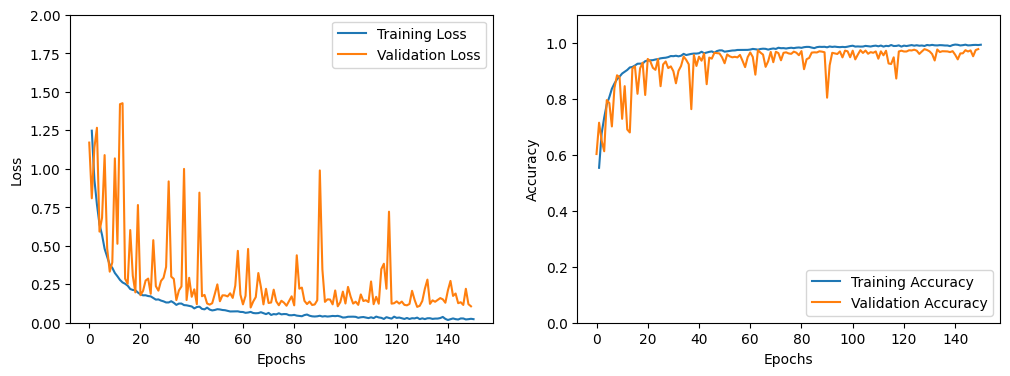

In [24]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [25]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 150) - Validation Loss: 0.111, Validation Accuracy: 0.977


In [26]:

start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.974
Test Time: 9.85 seconds ---> 0.16 minutes


### Class Accuracy

In [27]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
           
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []
y_score = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       450
           1       1.00      0.99      0.99       450
           2       0.93      0.97      0.95       450
           3       0.96      0.99      0.98       375
           4       0.99      0.98      0.99       375
           5       0.97      0.96      0.96       300
           6       0.98      0.92      0.95       375
           7       0.99      0.99      0.99       450
           8       0.98      0.98      0.98       375
           9       0.98      1.00      0.99       450

    accuracy                           0.97      4050
   macro avg       0.97      0.97      0.97      4050
weighted avg       0.98      0.97      0.97      4050

Class 0 Accuracy: 0.944
Class 1 Accuracy: 0.984
Class 2 Accuracy: 0.969
Class 3 Accuracy: 0.995
Class 4 Accuracy: 0.979
Class 5 Accuracy: 0.963
Class 6 Accuracy: 0.912
Class 7 Accuracy: 0.987
Class 8 Accuracy: 0.981
Cl

### Confusion Matrix

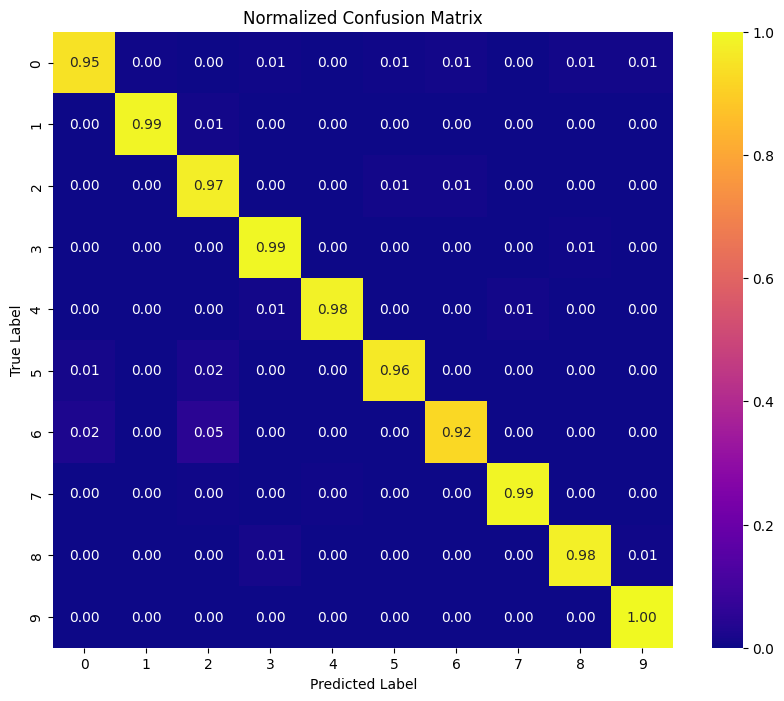

In [28]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='plasma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


### AUC ROC Curve

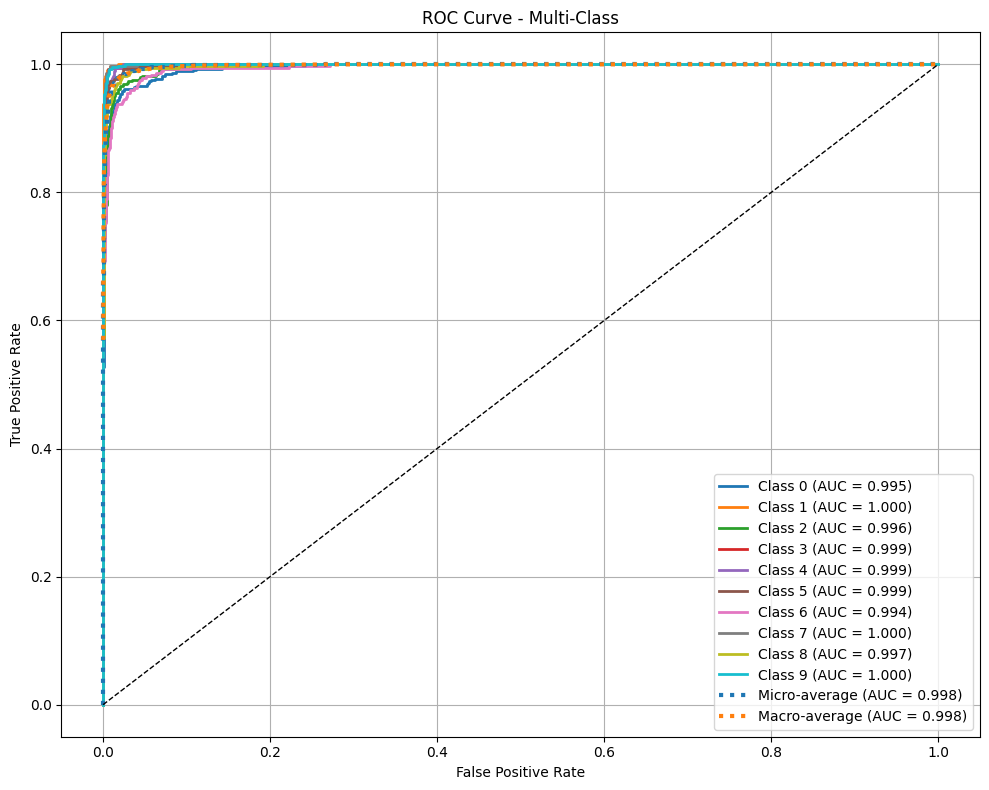

In [29]:
# Binarize the true labels
classes_list = sorted(list(set(y_true)))
y_true_bin = label_binarize(y_true, classes=classes_list)

fpr, tpr, roc_auc = {}, {}, {}

# Per-class ROC & AUC
for i in range(total_class):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(total_class)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(total_class):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= total_class
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ----- Plot ROC curves -----
plt.figure(figsize=(10, 8))

# Per-class curves
for i in range(total_class):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {classes_list[i]} (AUC = {roc_auc[i]:.3f})")

# Micro and Macro curves
plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=3,
         label=f"Micro-average (AUC = {roc_auc['micro']:.3f})")
plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=3,
         label=f"Macro-average (AUC = {roc_auc['macro']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()